In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
import json
import pickle
import six
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

## Data Cleaning
## Importing all the CSV files


In [4]:
AllCSV = [i for i in glob.glob('*.{}'.format('csv'))]
AllCSV

['MXvideos.csv',
 'INvideos.csv',
 'DEvideos.csv',
 'JPvideos.csv',
 'KRvideos.csv',
 'CAvideos.csv',
 'RUvideos.csv',
 'FRvideos.csv',
 'USvideos.csv',
 'GBvideos.csv']

## Reading all CSV files


In [8]:
all_dataframes = [] # list to store each data frame separately
for csv in AllCSV:
    df = pd.read_csv(csv, encoding='latin-1')
    df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
    all_dataframes.append(df)
all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canciÃ³n del principio se llama âEste esp...,MX
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX


## Fixing Data Types


In [9]:
for df in all_dataframes:
    # video_id 
    df['video_id'] = df['video_id'].astype('str') 
    
    # trending date
    df['trending_date'] = df['trending_date'].astype('str') 
    date_pieces = (df['trending_date']
                   .str.split('.')
                  )
    df['Year'] = date_pieces.str[0].astype(int)
    df['Day'] = date_pieces.str[1].astype(int)
    df['Month'] = date_pieces.str[2].astype(int)
    updatedyear = []
    for i in range(len(df)) : 
        y = df.loc[i, "Year"]
        newy = y+2000
        updatedyear.append(newy)
    for i in range(len(df)):
        newy = updatedyear[i]
        tr = df.loc[i, "Year"]
        df['Year'].replace(to_replace = tr, value = newy, inplace=True)
    del df['trending_date']
    df['trending_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format = "%Y-%m-%d")
    del df['Year']
    del df['Day']
    del df['Month']
    
    #title
    df['title'] = df['title'].astype('str')
    #channel_title
    df['channel_title'] = df['channel_title'].astype('str')
    #category_id
    df['category_id'] = df['category_id'].astype(str) 
    
    #tags
    df['tags'] = df['tags'].astype('str')
    
    # views, likes, dislikes, comment_count are already in correct data types i.e int64
    
    #thumbnail_link
    df['thumbnail_link'] = df['thumbnail_link'].astype('str') 
    
    #description
    df['description'] = df['description'].astype('str')
    
    # Changing comments_disabled, ratings_disabled, video_error_or_removed from bool to categorical
    df['comments_disabled'] = df['comments_disabled'].astype('category') 
    df['ratings_disabled'] = df['ratings_disabled'].astype('category') 
    df['video_error_or_removed'] = df['video_error_or_removed'].astype('category') 
    
    # publish_time 
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

## Separating ‘publish_time’ into ‘publish_date’ and ‘publish_time’


In [10]:
for df in all_dataframes:
    df.insert(4, 'publish_date', df['publish_time'].dt.date) # loc, column name, values for column to be inserted
    df['publish_time'] = df['publish_time'].dt.time
# Changing data type for 'publish_date' from object to 'datetime64[ns]'
for df in all_dataframes:
     df['publish_date'] = pd.to_datetime(df['publish_date'], format = "%Y-%m-%d")

In [11]:
# We can use any index from 0 to 9 inclusive (for each of the 10 dataframes
all_dataframes[1].dtypes

video_id                          object
title                             object
channel_title                     object
category_id                       object
publish_date              datetime64[ns]
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled               category
ratings_disabled                category
video_error_or_removed          category
description                       object
country                           object
trending_date             datetime64[ns]
dtype: object

In [12]:
for df in all_dataframes:
    df.set_index('video_id', inplace=True)


## Examining Missing Values


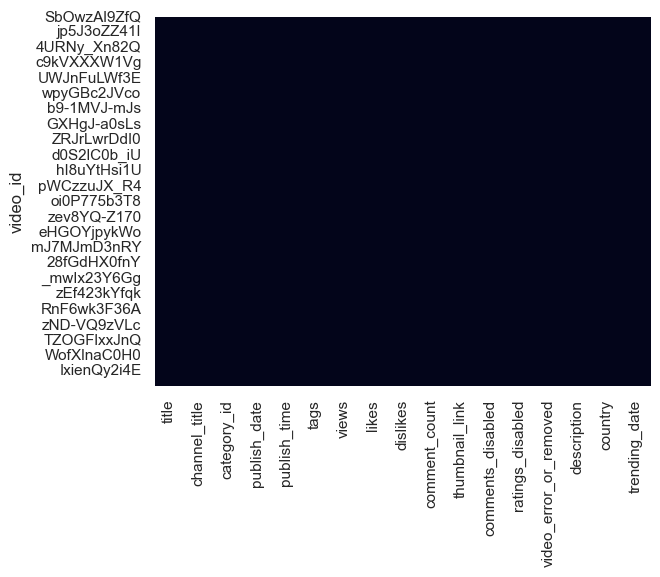

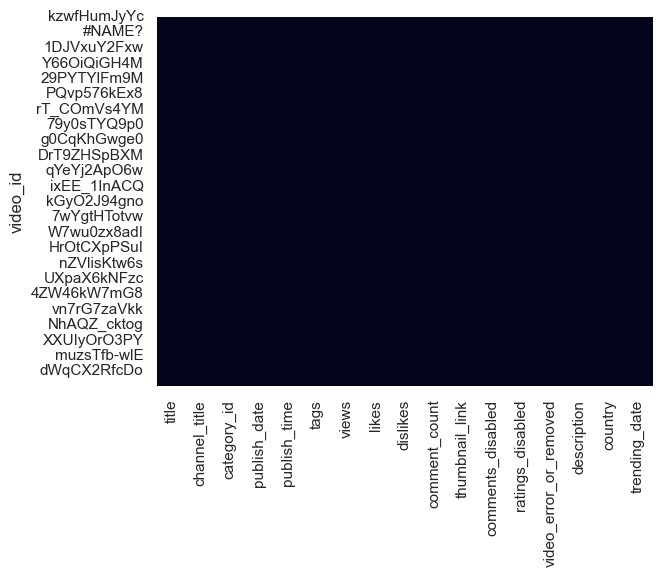

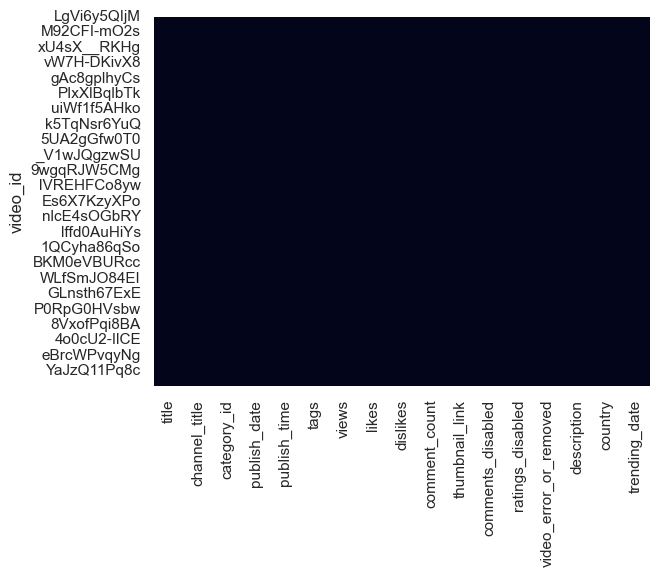

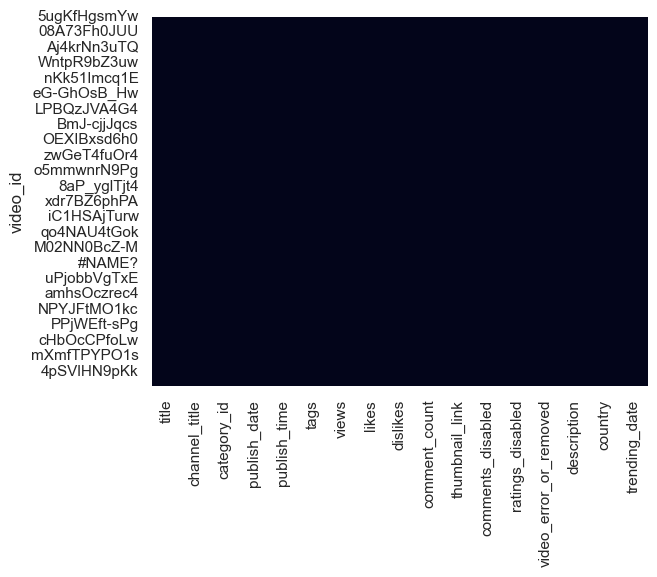

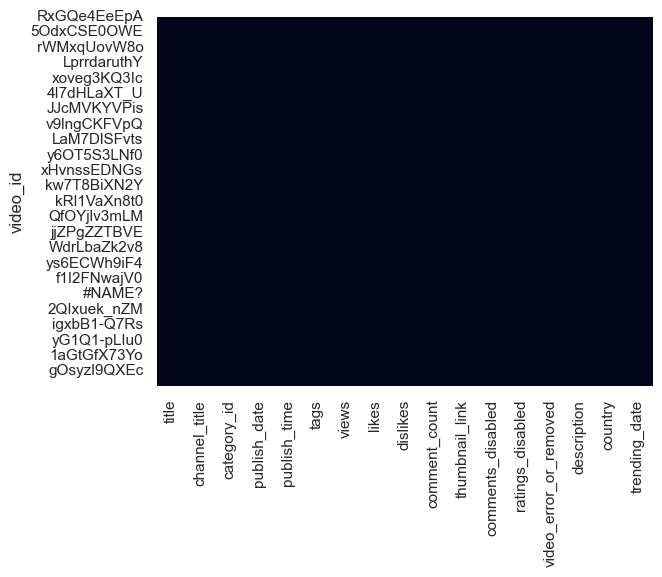

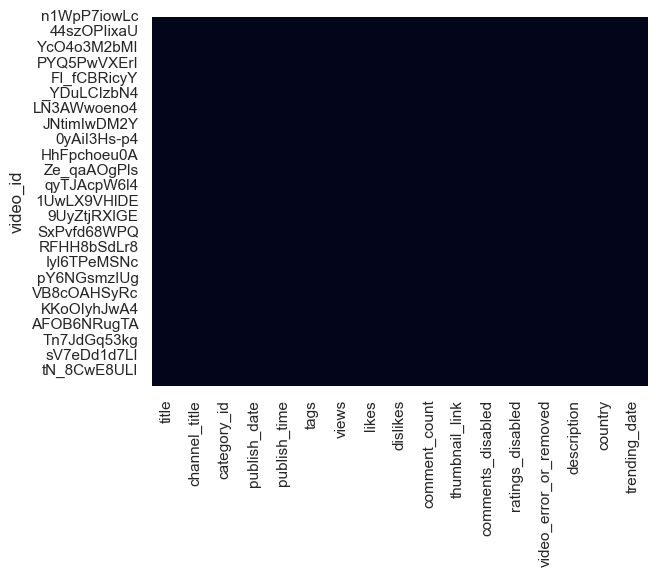

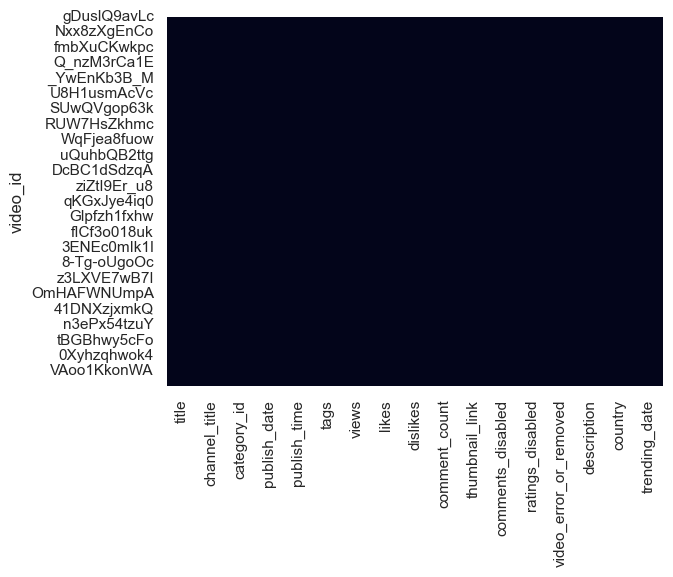

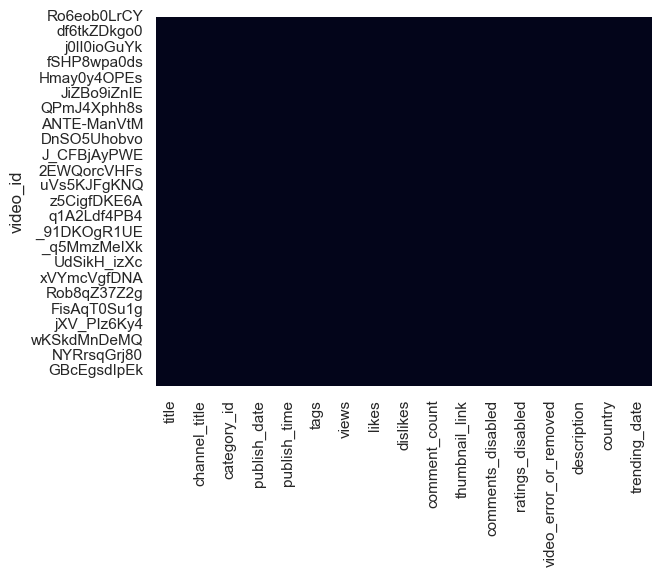

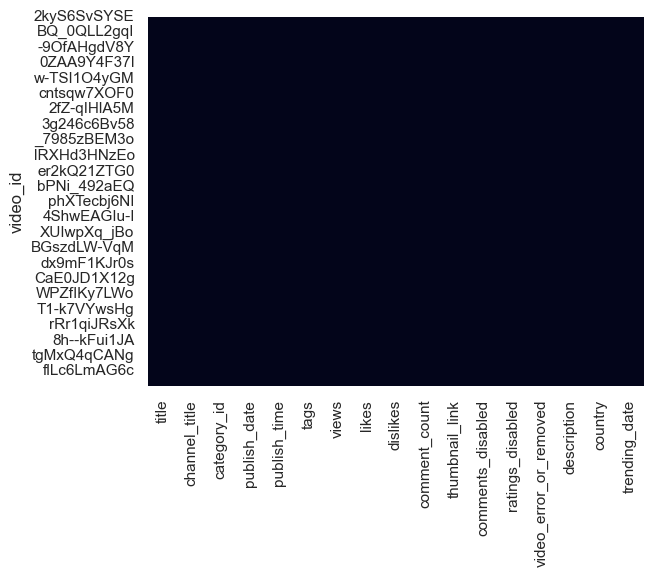

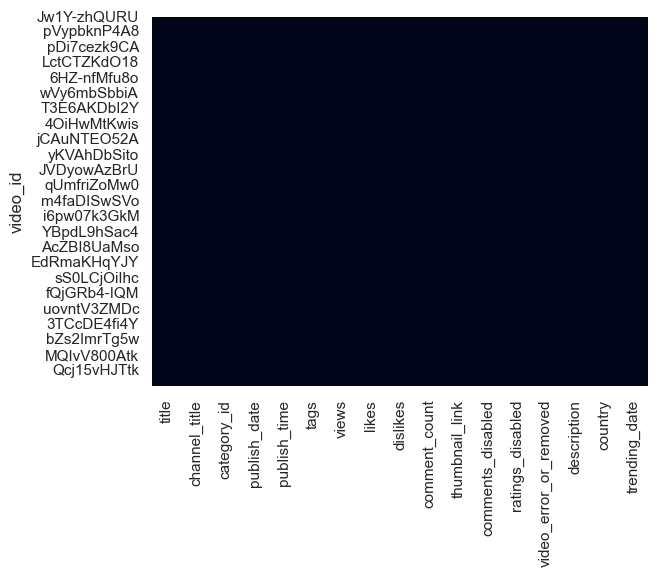

<Figure size 640x480 with 0 Axes>

In [13]:
for df in all_dataframes:
    sns.heatmap(df.isnull(), cbar=False)
    plt.figure()

## Combining Every Dataframe Into One Huge Dataframe


In [14]:
combined_df = pd.concat(all_dataframes)

In [15]:
# Making copy of original dataframe
backup_df = combined_df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')
# Sorting according to latest trending date while removing duplicates
combined_df = combined_df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id',keep='first').set_index('video_id')
# Doing the same above operation for each of the individual dataframes in the list we created earlier
for df in all_dataframes:
    df = df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')
# Printing results
combined_df[['publish_date','publish_time','trending_date', 'country']].head()
# It can be seen that latest publications and trending information is at the top now

,publish_date,publish_time,trending_date,country
video_id,,,,
4YFo4bdMO8Q,2018-05-11,04:06:35,2018-06-14,GB
L_cxNGfEd_0,2018-06-13,10:54:55,2018-06-14,FR
ENVlcPpTuh4,2018-06-13,14:56:22,2018-06-14,KR
5BeWvP521s8,2018-06-12,08:00:02,2018-06-14,KR
nOUlB0i2MaA,2018-06-13,19:10:31,2018-06-14,KR


## Inserting Category Column


In [16]:
# read file
with open('US_category_id.json', 'r') as f:  # reading one randomly selected json files to make sense of its contents
    data = f.read()
# parse file
obj = json.loads(data)
# printing
obj

{'kind': 'youtube#videoCategoryListResponse',
 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM"',
 'items': [{'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"',
   'id': '1',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Film & Animation',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"',
   'id': '2',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Autos & Vehicles',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"',
   'id': '10',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Music',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/HwXKamM1Q20q9BN-oBJavSGkfDI"',
   'id': '15',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdnt

In [17]:
category_id = {}
with open('DE_category_id.json', 'r') as f:
    d = json.load(f)
    for category in d['items']:
        category_id[category['id']] = category['snippet']['title']
combined_df.insert(2, 'category', combined_df['category_id'].map(category_id))
backup_df.insert(2, 'category', backup_df['category_id'].map(category_id))
for df in all_dataframes:
    df.insert(2, 'category', df['category_id'].map(category_id))
# Printing cleaned combined dataframe
combined_df.head(3)

,title,channel_title,category,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,
4YFo4bdMO8Q,KYLE - Ikuyo feat. 2 Chainz & Sophia Black [A...,SuperDuperKyle,Music,10,2018-05-11,04:06:35,"Kyle|""SuperDuperKyle""|""Ikuyo""|""2 Chainz""|""Soph...",607552,18271,274,1423,https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg,False,False,False,Debut album 'Light of Mine' out now: http://ky...,GB,2018-06-14
L_cxNGfEd_0,CLASSE PAS CLASSE - PAROLE DE CHAT,Parole de chat,Pets & Animals,15,2018-06-13,10:54:55,"classe|""pas classe""|""parole""|""parole de chat""|...",186468,28742,233,2168,https://i.ytimg.com/vi/L_cxNGfEd_0/default.jpg,False,False,False,"Classe pas classe, hommage aux Robins des bois...",FR,2018-06-14
ENVlcPpTuh4,"[ì í2018, íì¸í¡í¡] ìë¬´ë¦¬ ì§ë¬¸ì´...",MBCNEWS,News & Politics,25,2018-06-13,14:56:22,"MBC|""MBCë´ì¤""|""ë´ì¤ë°ì¤í¬""|""newsdesk""|""...",836427,2254,801,3551,https://i.ytimg.com/vi/ENVlcPpTuh4/default.jpg,False,False,False,"ì í2018, 6.13ì§ë°©ì ê±°, ê°íë°©ì¡, ì...",KR,2018-06-14


In [18]:
combined_df['category'].unique()


array(['Music', 'Pets & Animals', 'News & Politics', 'Sports', 'Comedy',
       'Film & Animation', 'People & Blogs', 'Entertainment',
       'Howto & Style', 'Education', 'Gaming', nan, 'Autos & Vehicles',
       'Travel & Events', 'Shows', 'Science & Technology', 'Movies',
       'Trailers'], dtype=object)

## Exploratory Data Analysis
Ratio of likes-dislikes in different categories


<AxesSubplot: xlabel='ratio', ylabel='category'>

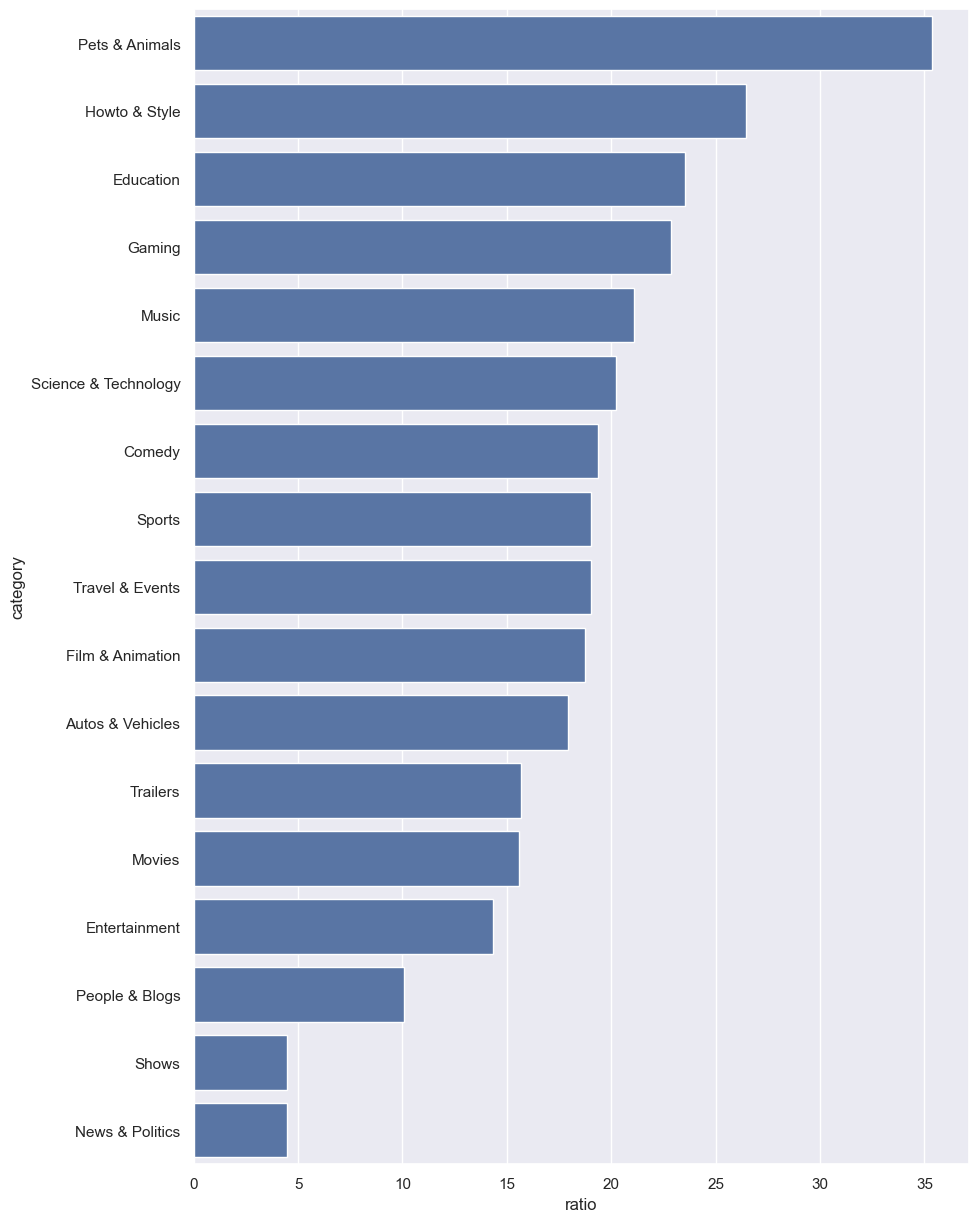

In [19]:
# calculating total likes for each category
likesdf = combined_df.groupby('category')['likes'].agg('sum')
# calculating total dislikes for each category
dislikesdf = combined_df.groupby('category')['dislikes'].agg('sum')
# calculating ratios of likes to dislikes
ratiodf = likesdf/dislikesdf 
# most liked category to appear on top
ratiodf = ratiodf.sort_values(ascending=False).reset_index()
# plotting bar chart
ratiodf.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=ratiodf,
            label="Likes-Dislikes Ratio", color="b")

In [ ]:
## Observations:
We see that videos belonging to the pets and animals categories have the highest ratio of 
likes to dislikes videos among the trending categories whereas new and politics videos have the least. From this we can infer that people are less divided on the content of videos based on entertainment 
than compared to topics such as new, whose content can lead to a division of opinions among the user.

## Users like videos from which category more?


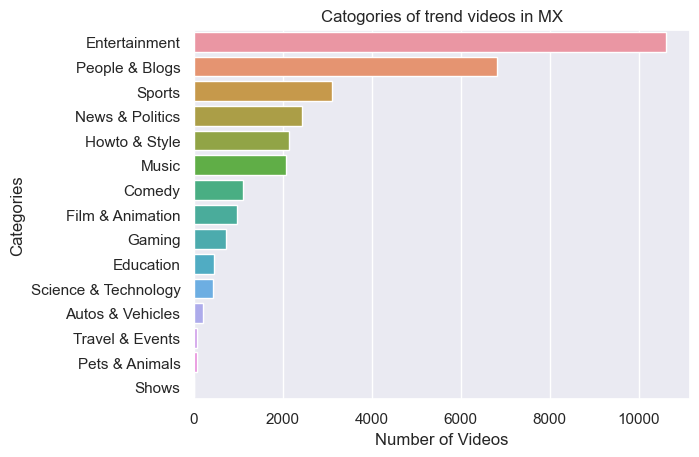

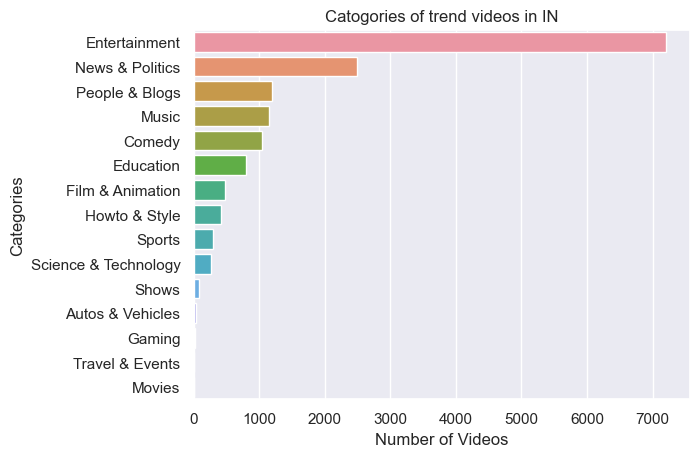

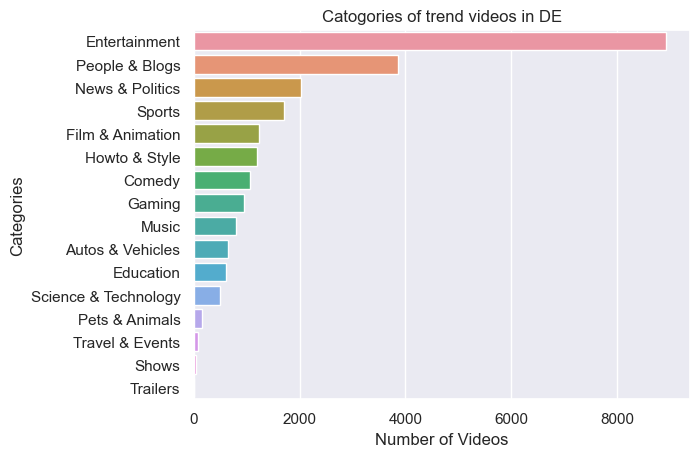

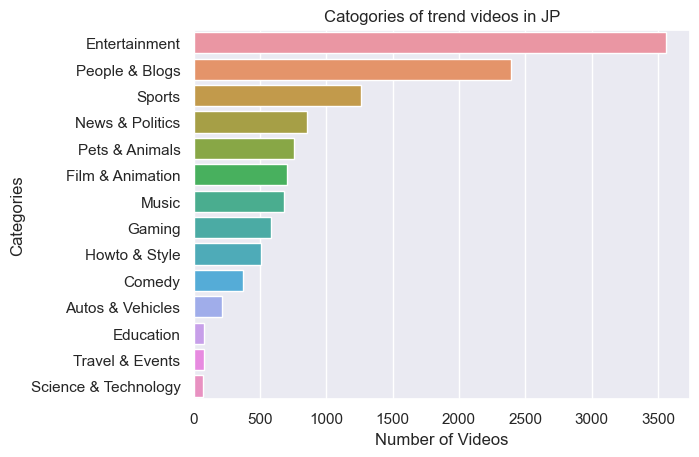

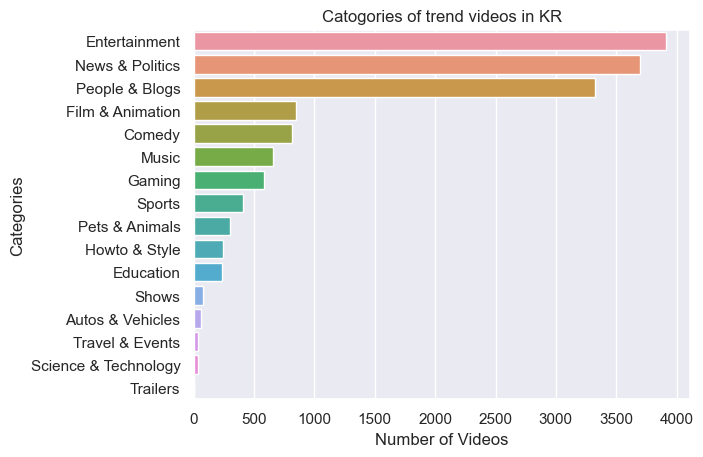

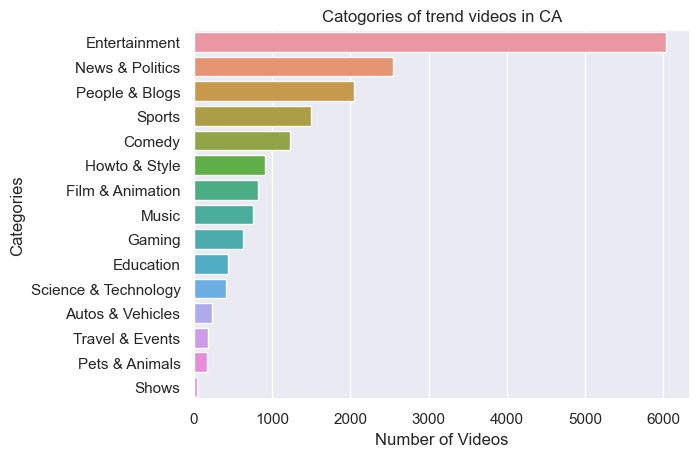

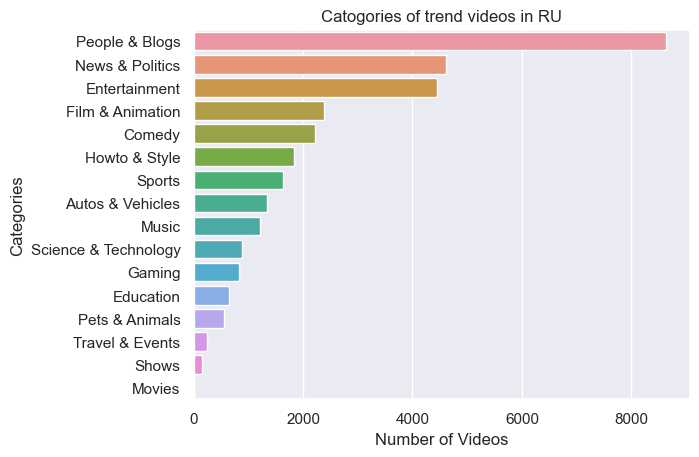

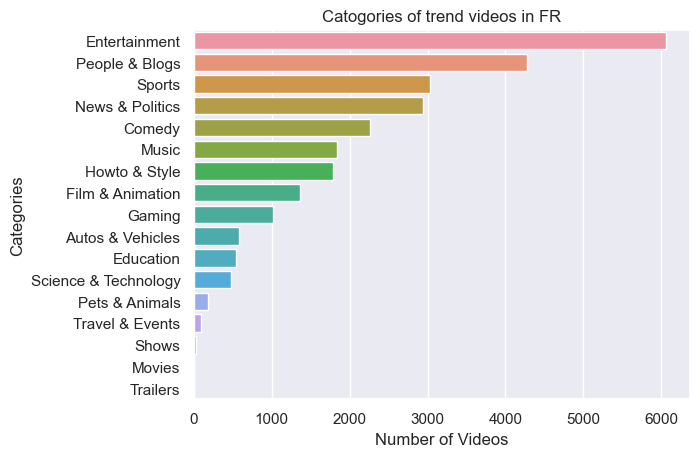

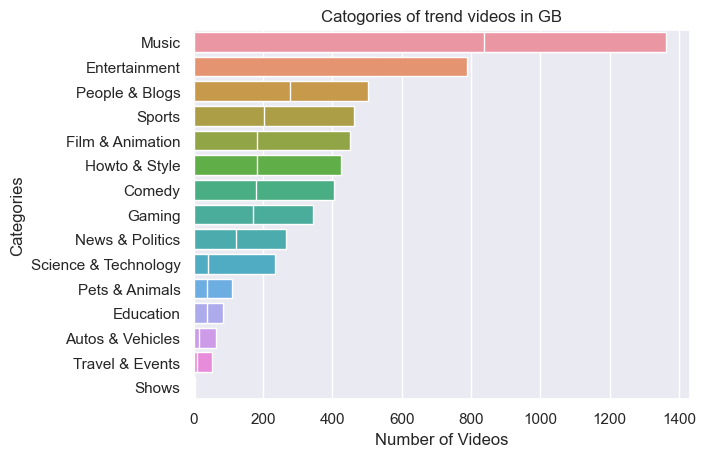

<Figure size 640x480 with 0 Axes>

In [21]:
# Getting names of all countries
countries = []
allcsv = [i for i in glob.glob('*.{}'.format('csv'))]
for csv in allcsv:
    c = csv[0:2]
    countries.append(c)
for country in countries:
    if country == 'US':
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['index'], x=tempdf['category'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Catogories of trend videos in " + country)
    else:
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['index'], x=tempdf['category'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Catogories of trend videos in " + country)
        plt.figure()




## Top 5 videos that are on trending in each country?


In [22]:
temporary = []
for df in all_dataframes:
    temp = df
    temp = temp.reset_index().sort_values(by = ['views'], ascending=False)
    temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
    temp.set_index('video_id', inplace=True)
    temp = temp.head(5) # top 5 that are on trending
    temporary.append(temp)
# Printing 3 randomly selected countries
temporary[2][['title', 'channel_title', 'category', 'views', 'likes']]

,title,channel_title,category,views,likes
video_id,,,,,
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,Entertainment,113876217,2811217
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,Entertainment,80360459,2513103
7C2z4GqqS5E,BTS (ë°©íìë ë¨) 'FAKE LOVE' Official MV,ibighit,Music,73463137,4924056
VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,73432600,2478908
_I_D_8Z4sJE,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,Music,50896717,550476


## Is the most liked video also the most trending video?


In [26]:
temporary = [] # to store results for each country
for df in all_dataframes:
    temp = df
    temp = temp.reset_index().sort_values(by = ['likes'], ascending=False)
    temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
    temp.set_index('video_id', inplace=True)
    temp = temp.head(5) # top 5 that are most liked
    temporary.append(temp)
# Printing 3 randomly selected results
temporary[0][['views', 'likes']]

,views,likes
video_id,,
7C2z4GqqS5E,62796390,4470923
FlsCjmMhFmw,100912384,2656698
6ZfuNTqbHE8,74789251,2444976
kTlv5_Bs8aw,20573162,2320666
OK3GJ0WIQ8s,10695328,2050610


## Maximum number of days to trending status for a video?


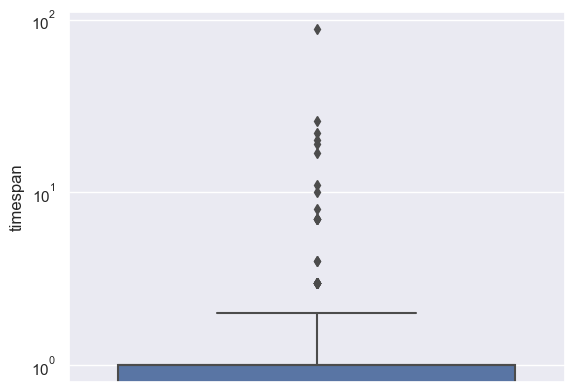

/var/folders/65/f_nvng1s4plcb6xt93d2f8yr0000gn/T/ipykernel_66056/2275980647.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(to_trending.value_counts(),bins='rice',kde=False)


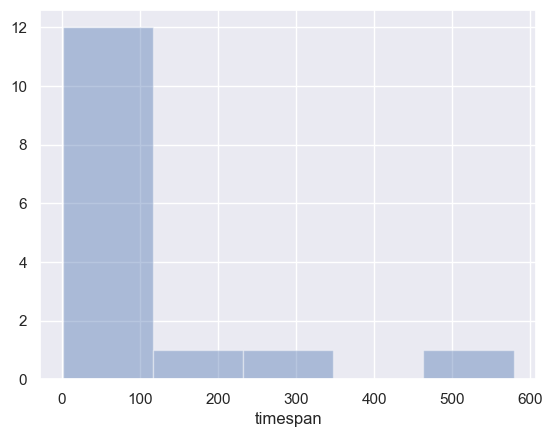

In [27]:
# Calculating days between publish and trending date
temporary = []
for data in all_dataframes:
    temp = data
    temp['timespan'] = (temp['trending_date'] - temp['publish_date']).dt.days
    temporary.append(temp)
# Plotting
to_trending = temporary[0].sample(1000).groupby('video_id').timespan.max() # CA
sns_ax = sns.boxplot(y = to_trending)
_ = sns_ax.set(yscale = "log")
plt.show()
_ = sns.distplot(to_trending.value_counts(),bins='rice',kde=False)

## Users like videos from which category more?


In [28]:
temp = combined_df
temp = temp.groupby('category')['views', 'likes'].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='likes', ascending=False).head()
temp

/var/folders/65/f_nvng1s4plcb6xt93d2f8yr0000gn/T/ipykernel_66056/1729928692.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby('category')['views', 'likes'].apply(lambda x: x.astype(int).sum())


,views,likes
category,,
Entertainment,17588672171,471875260
Music,18175195668,444810351
Comedy,4573398180,218752102
People & Blogs,5606736781,157767436
Howto & Style,2215633882,77250724


## Users comment on which category the most?


In [29]:
temp = combined_df
temp = temp.groupby('category')['views','likes', 'comment_count'].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='comment_count', ascending=False).head()
temp

/var/folders/65/f_nvng1s4plcb6xt93d2f8yr0000gn/T/ipykernel_66056/399013992.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby('category')['views','likes', 'comment_count'].apply(lambda x: x.astype(int).sum())


,views,likes,comment_count
category,,,
Entertainment,17588672171,471875260,68370777
Music,18175195668,444810351,36232007
People & Blogs,5606736781,157767436,24662982
Comedy,4573398180,218752102,23294917
News & Politics,3470697996,53467988,14956906


## Correlation between views, likes, dislikes, and comments


In [50]:
col = ['views', 'likes', 'dislikes', 'comment_count']
corr = combined_df[col].corr()
corr


,views,likes,dislikes,comment_count
views,1.000000,0.768352,0.378172,0.423572
likes,0.768352,1.000000,0.435397,0.700513
dislikes,0.378172,0.435397,1.000000,0.667473
comment_count,0.423572,0.700513,0.667473,1.000000
